# Executive Summary
In general, this is a Natural Language Processing (NLP) project focusing on finding out insights on the current data science/analytics job market.

The followings are the various models used in this project:

<strong>Classifiers</strong>: Logistic Regression (SGD Classifier), SVM (SGD classfier), XGB Classifier, Random Forest Classifier

<strong>Regressors</strong>: Linear Regression, Lasso Regression, EleasticNet Regression

Explanations of each models can be found on the web if you're interested to find out. In simplest terms, you may see classifier as a model to predict categories while regressor is a model to predict the actual numerical values.

The project is spilt into 3 phases: Data Collecting, Data Cleaning, and Modelling + Analysing.


<strong>Data Collecting</strong>

Our data are scrapped from the following 8 websites: sgintern, efinancialcareers, glassdoor, mycareersfuture, indeed, jobstreet, jobcentral, jobsbank.sg, and stjobs.

Particularly, we are interested in the job titles, job descriptions, salary, and hiring companies.


<strong>Data Cleaning</strong>

We have to clean our data before they are ready for modelling. Below are the methods used for cleaning the data.

job titles: Aggregate into simple groups/categories. Ex. Data Scientist, Data Analysts, Data Engineers, etc. 

job descriptions: Symbols and numbers are removed. Meaningless words like "is" , "are", "a" are removed. Words that are merged will be segmented. Ex. "yourrole" to "your role". Remaining words are then converted to it stemmed forms ("business" and "businesses" are converted "busi"). The last step is to put the remaining words into its own categories as it is the input format for the models. These categories are defined as "features".

salary: Data with unspecified salaries are dropped. Those labelled as "negotiable" is replaced with 50th percentile. Those labelled as "competitive" is replaced with 75th percentile. Salaries given in range will be replaced with their average values, (max + min)/2. 


<strong>Modelling + Analysing</strong>

For the analysis, we are using job description to predict both the salary range and the job category.

Clean data will be spilt in two portions. The training data, used to train our models; and the test data, used for testing our models' performance. 

The training data is fed into the Classifiers and regressors for training first, followed by the test data to verify the performance. 

For classifiers, a good predicting model should have high f1 scores (ranging from 0 to 1) and high ROC area (ranging from 0 to 1).

For regressors, the better the model, the higher the score (ranging from 0 to 1).

After finding good/acceptable model (one with the best scores), we will examine the model and check which words/features are labeled as important by the model. To do so, we simply examine the coeffients assigned to each feature/word used in the modeling. The higher the coefficient, the more important it is.  

As a result, factors that impact salary and factors that distinguish jobs can be inferred from these coeffients.


## Dependency Setup

In [331]:
from segment.segmenter import Analyzer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import re
import nltk
nltk.download('punkt')
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

[nltk_data] Downloading package punkt to C:\Users\Guan
[nltk_data]     Fong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Class for displaying tables side by side

In [97]:
class display_css(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""

    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                     for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                       for a in self.args)

# QUESTION 1: Factors that impact salary

## EDA and Data Cleaning

In [2]:
df = pd.read_csv("./combined4.csv")

In [3]:
df.info()
df["salary"].value_counts().head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 5 columns):
job_title          1506 non-null object
job_description    1506 non-null object
salary             1506 non-null object
company            1506 non-null object
salary_min         1506 non-null object
dtypes: object(5)
memory usage: 58.9+ KB


Not Specified    359
4500             345
6000             135
5000              63
4000              38
Name: salary, dtype: int64

In [4]:
df = df[(df["salary"] == "Not Specified") == False]

In [5]:
df.head()

,job_title,job_description,salary,company,salary_min
0,"VP, Business Data Analyst, Enterprise Data Str...","VP, Business Data Analyst, Enterprise Data St...",6000,United Overseas Bank,5000
1,Data Architect,An exciting Data Architect role has just bec...,15000,Robert Walters (Singapore) Pte Ltd,13333
2,Data Analyst,Leading the way in International Banking. We...,4500,Standard Chartered Bank Singapore,4500
3,Data Architect,Leading the way in International Banking. We...,4500,Standard Chartered Bank Singapore,4500
4,Data Manager,"This role reports to the project lead, Retai...",4500,Standard Chartered Bank Singapore,4500


In [6]:
working_df = df

In [7]:
working_df["salary"]= working_df["salary"].apply(lambda x : int(x))

In [8]:
X = working_df["job_description"]
y = working_df["salary"]

### Remove symbols and numbers

In [9]:
X = X.apply(lambda x : re.sub('[^a-zA-Z]', ' ', x))

### Segment merged words and convert words to its stemmed forms

In [10]:
stemmer = SnowballStemmer('english')
def apply_stemmer(description):
    desc = TextBlob(description)
    func_list = [stemmer.stem(word) for word in desc.words]
    result = " ".join(func_list)
    return result

e = Analyzer('en')
def apply_words_split(description):
    result = []
    desc = TextBlob(description)
    func_lists = [e.segment(word) for word in desc.words]
    for func_list in func_lists:
        for ele in func_list:
            result.append(ele)
    result = " ".join(result)
    return result

X = X.apply(lambda x : apply_words_split(x))
X = X.apply(lambda x : apply_stemmer(x))


### Split the dataset for training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Convert the string of words into categories/features

In [327]:
# use TfidfVectorizer to create document-term matrices from X_train and X_test
vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=4)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [13]:
# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(860, 11084)

## Linear Regression (Baseline)
The score is useless. Linear regression is bad for NLP

In [14]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train_dtm, y_train, cv=10)

print lr_scores
print np.mean(lr_scores)

[-1.24081927  0.24057775  0.15568209 -0.18869729 -0.77360815 -0.10306095
  0.34993492  0.24758679 -0.45377428 -0.41589439]
-0.21820727780420301


## Lasso Regression
This is meant for optimizing the lasso regression. Running the following code took me 23.9mins of 100% CPU running. You may skip this section by replacing optimal_lasso.alpha_ with 0.7615582528743544 in the next section.

In [15]:
optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1, n_jobs= 6)
optimal_lasso.fit(X_train_dtm, y_train)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.7615582528743544


The score for lasso regression is around 0.37. This is much better than linear regression

In [16]:
# change the alpha=optimal_lasso.alpha_ into alpha=0.7615582528743544 if you're not running the previous section
lasso = Lasso(alpha=optimal_lasso.alpha_, fit_intercept = True)

lasso_scores = cross_val_score(lasso, X_train_dtm, y_train, cv=10)
lasso.fit(X_train_dtm, y_train)
print lasso_scores
print np.mean(lasso_scores)
lasso_coefs = pd.DataFrame({'variable':vect.get_feature_names(),
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))

[0.30732345 0.38911665 0.41433262 0.21642908 0.47199167 0.3977521
 0.5208864  0.61183077 0.06339885 0.32157981]
0.3714641405967151
Percent variables zeroed out: 0.9741068206423674


## ElasticNet Regression
This section is meant for optimizing the ElasticNet regression. Running the following code took me 3.5mins of 100% CPU running. You may skip this section by replacing optimal_EN.alpha_ with 0.08699411638845501 in the next section.

In [17]:
optimal_EN = ElasticNetCV(n_alphas=1000, cv=10, verbose=1, n_jobs= 6)
optimal_EN.fit(X_train_dtm, y_train)

print optimal_EN.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.08699411638845501


The score is pretty bad when compared to lasso's 0.37

In [18]:
# change the alpha=optimal_EN.alpha_ into alpha=0.08699411638845501 if you're not running the previous section
EN = ElasticNet(alpha=optimal_EN.alpha_ , fit_intercept = True)
EN_scores = cross_val_score(EN, X_train_dtm, y_train, cv=10)
EN.fit(X_train_dtm, y_train)
print EN_scores
print np.mean(EN_scores)

[0.03023398 0.05522801 0.08491835 0.10130291 0.14952298 0.09941047
 0.07416781 0.08522899 0.05253494 0.07088319]
0.08034316240069242


## XGB Regression

This section is used to prepared the input format suitable for XGB models

In [19]:
svd = TruncatedSVD(n_components=100)
svd.fit(X_train_dtm)  
X_train_dtm_svd = svd.transform(X_train_dtm)
X_test_dtm_svd = svd.transform(X_test_dtm)

In [21]:
XGB_reg  = XGBRegressor(n_estimators=100, reg_alpha = 10000)
XGB_reg.fit(X_train_dtm_svd, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=10000, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Better score than ElasticNet, but worse than lasso

In [23]:
xgb_scores = cross_val_score(XGB_reg, X_train_dtm_svd, y_train, cv=10)
print xgb_scores
print np.mean(xgb_scores)

y_pred = XGB_reg.predict(X_test_dtm_svd)

r2_score(y_test, y_pred)

[0.21100444 0.2820706  0.32818949 0.26471647 0.38449974 0.35141906
 0.32857989 0.44169286 0.14880087 0.27618046]
0.30171539048421175


0.2874919815213459

## Classification Preparation

In [52]:
def convert_to_percentile(number):
    if((number <= 4375)):
        return "25 pecentile"
    elif((number> 4375) & (number <= 4500)):
        return "50 percentile"
    elif((number > 4500) & (number <= 6000)):
        return "75 percentile"
    else:
        return "above 75 pecentile"
        
        
y_train_clf = y_train.apply(convert_to_percentile)
y_test_clf = y_test.apply(convert_to_percentile)

## SGD Classifier

In [53]:
tuned_parameters = {'alpha': [10**a for a in range(-6, 5)], 
                   'penalty': ['elasticnet', 'l1', 'l2'],
                   'loss': ['hinge', 'log']}
clf = GridSearchCV(SGDClassifier( max_iter=10, shuffle=False, verbose=False, n_jobs=10, average=False, class_weight='balanced'), tuned_parameters, cv=5, scoring='f1_macro')

# Now clf is the best classifier found given the search space
clf.fit(X_train_dtm, y_train_clf)

# Check the propeties of your model
print(clf.best_params_)    

print classification_report(y_test_clf, clf.predict(X_test_dtm))



{'penalty': 'l2', 'alpha': 0.001, 'loss': 'log'}
                    precision    recall  f1-score   support

      25 pecentile       0.73      0.67      0.70        76
     50 percentile       0.56      0.62      0.59        86
     75 percentile       0.66      0.55      0.60        67
above 75 pecentile       0.55      0.62      0.58        58

       avg / total       0.62      0.62      0.62       287



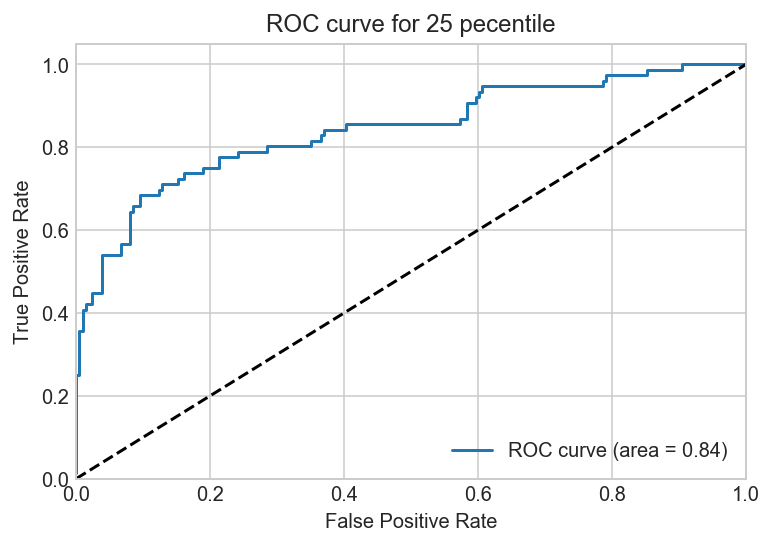

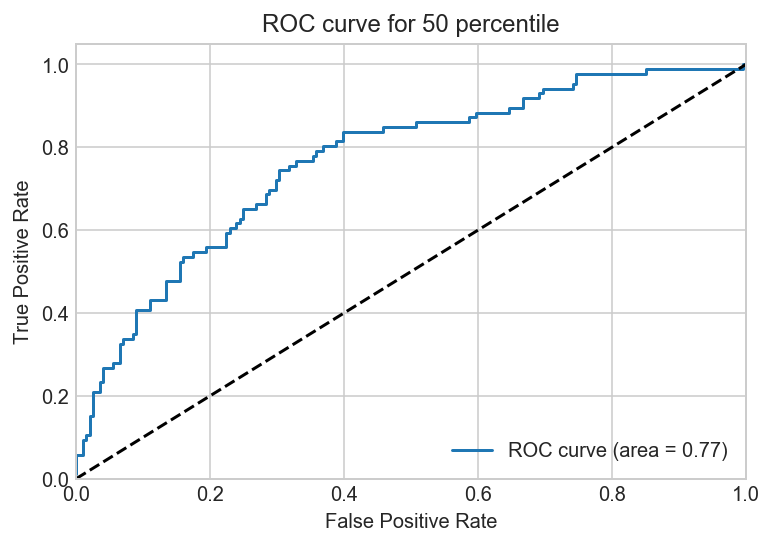

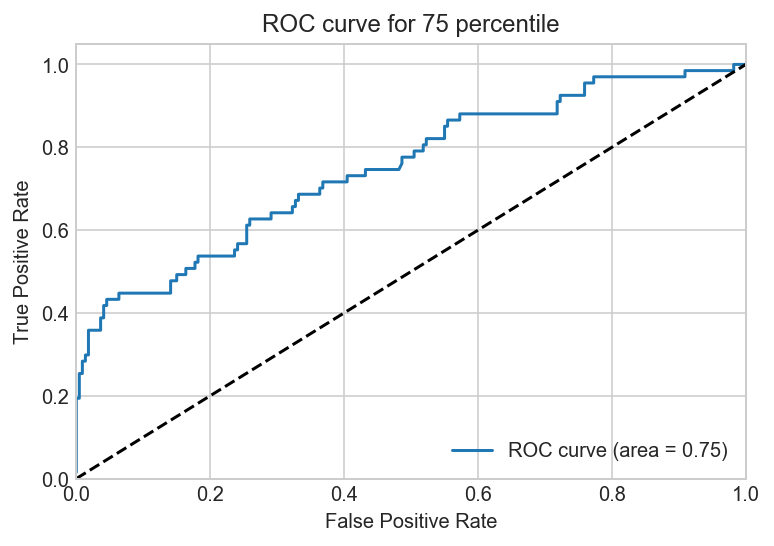

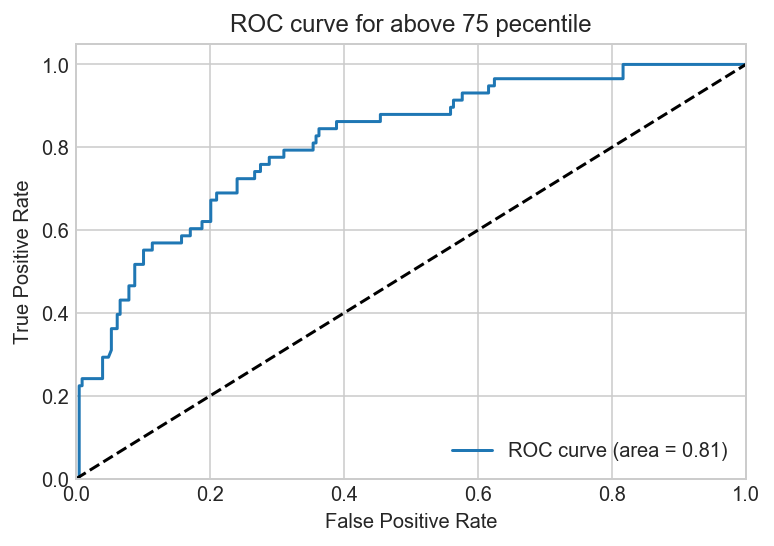

In [54]:
categories =["25 pecentile", "50 percentile" ,"75 percentile", "above 75 pecentile"]

y_score = clf.decision_function(X_test_dtm)
y_test_roc = label_binarize(y_test_clf, classes=categories)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(len(categories)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + str(categories[i]))
    plt.legend(loc="lower right")
    plt.show()

In [330]:
clf_coefs_0 = pd.DataFrame({'feature':vect.get_feature_names(),
                            '25 Percentile':clf.best_estimator_.coef_[0]})
clf_coefs_1 = pd.DataFrame({'feature':vect.get_feature_names(),
                         '50 Percentile':clf.best_estimator_.coef_[1]})
clf_coefs_2 = pd.DataFrame({'feature':vect.get_feature_names(),
                         '75 Percentile':clf.best_estimator_.coef_[2]})
clf_coefs_3 = pd.DataFrame({'feature':vect.get_feature_names(),
                         'Above 75 Percentile':clf.best_estimator_.coef_[3]})

clf_coefs_0.sort_values('25 Percentile', inplace=True, ascending=False)
clf_coefs_1.sort_values('50 Percentile', inplace=True, ascending=False)
clf_coefs_2.sort_values('75 Percentile', inplace=True, ascending=False)
clf_coefs_3.sort_values('Above 75 Percentile', inplace=True, ascending=False)

display_css('clf_coefs_0.head(50)','clf_coefs_1.head(50)', 
            'clf_coefs_2.head(50)', 'clf_coefs_3.head(50)') 


,25 Percentile,feature
114,0.849114,account
6038,0.844907,media
3969,0.838183,fluent
3302,0.795323,english
8603,0.769322,sale
5930,0.716959,market
2880,0.703078,diploma
1312,0.699108,cabl
852,0.691604,atm
824,0.676163,assist


You can infer from the 4 tables above which features/keywords have strong impacts on its group

## XGB Classifier

In [55]:
xgb_clf = XGBClassifier(n_estimators=100)
xgb_scores = cross_val_score(xgb_clf, X_train_dtm_svd, y_train_clf, cv=10)
xgb_clf.fit(X_train_dtm_svd, y_train_clf)
print xgb_scores
print np.mean(xgb_scores)
print classification_report(y_test_clf, xgb_clf.predict(X_test_dtm_svd))
print accuracy_score(y_test_clf, xgb_clf.predict(X_test_dtm_svd))

C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

[0.57303371 0.45977011 0.56321839 0.52325581 0.47674419 0.51764706
 0.56470588 0.51764706 0.52941176 0.6       ]
0.5325433978318177
                    precision    recall  f1-score   support

      25 pecentile       0.75      0.61      0.67        76
     50 percentile       0.51      0.63      0.57        86
     75 percentile       0.47      0.57      0.51        67
above 75 pecentile       0.57      0.40      0.47        58

       avg / total       0.58      0.56      0.56       287

0.5609756097560976


C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


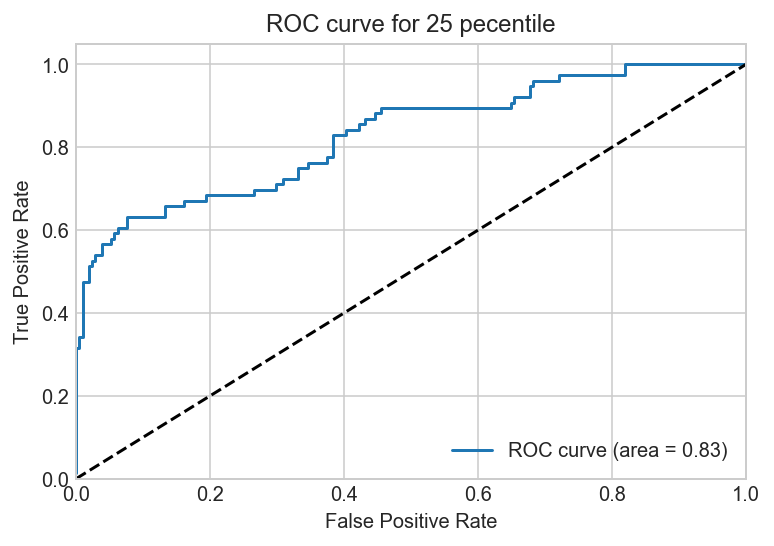

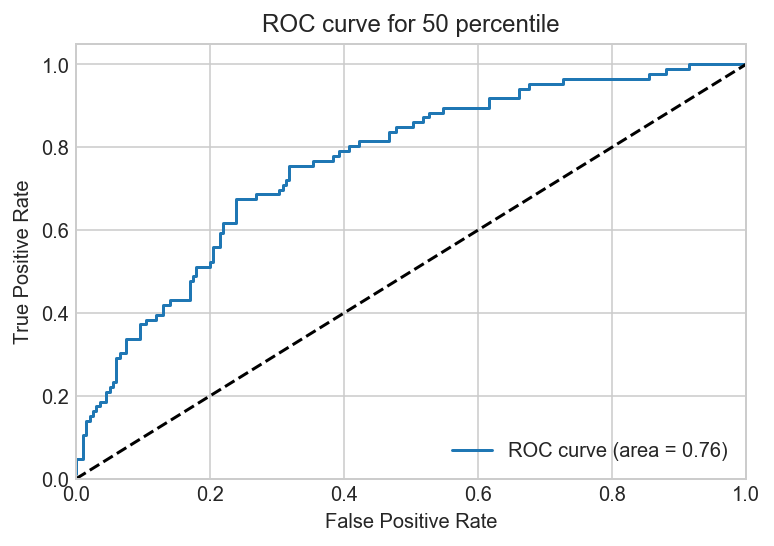

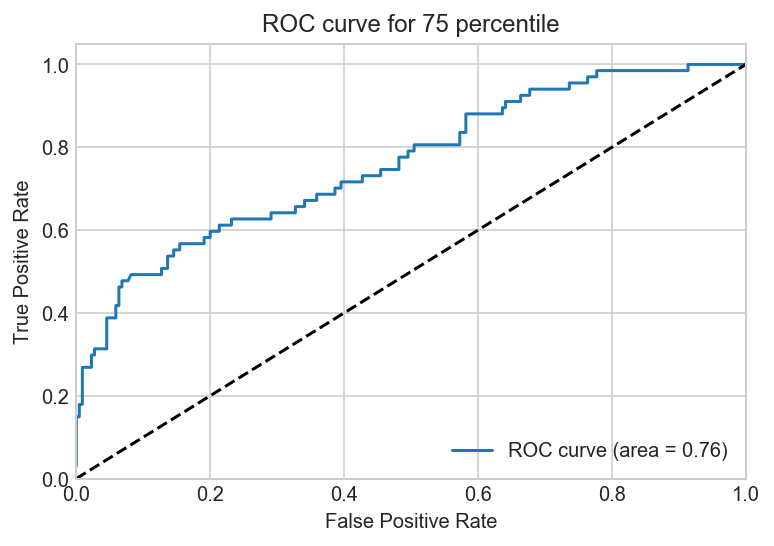

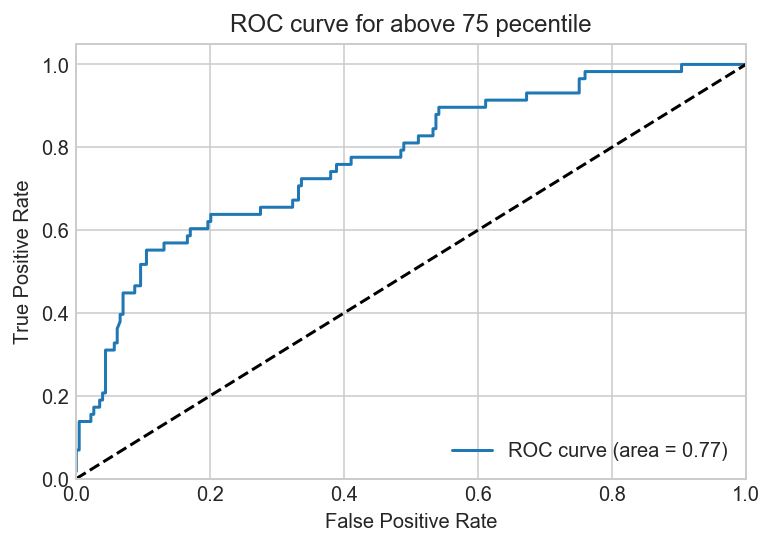

In [62]:
categories =["25 pecentile", "50 percentile" ,"75 percentile", "above 75 pecentile"]

y_score = xgb_clf.predict_proba(X_test_dtm_svd)
y_test_roc = label_binarize(y_test_clf, classes=categories)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(len(categories)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + str(categories[i]))
    plt.legend(loc="lower right")
    plt.show()

## Bonus: Neural Networks

In [63]:
NN_clf = MLPClassifier(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), random_state=1)
NN_clf.fit(X_train_dtm, y_train_clf)
print classification_report(y_test_clf, NN_clf.predict(X_test_dtm))
print accuracy_score(y_test_clf, NN_clf.predict(X_test_dtm))

                    precision    recall  f1-score   support

      25 pecentile       0.71      0.74      0.72        76
     50 percentile       0.58      0.62      0.60        86
     75 percentile       0.61      0.51      0.55        67
above 75 pecentile       0.48      0.50      0.49        58

       avg / total       0.60      0.60      0.60       287

0.5993031358885017


## Bonus Problem
Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

In [318]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test_roc, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))


In [319]:
categories =["75 percentile"]
y_test_roc = label_binarize(y_test_clf, classes=categories)

y_scores = clf.predict_proba(X_test_dtm)[:, 2]
p, r, thresholds = precision_recall_curve(y_test_roc, y_scores)

# 0.45 gives a 1.0 precision. The following graph demonstrates it. 
precision_recall_threshold(p, r, thresholds, 0.45)

     pred_neg  pred_pos
neg       220         0
pos        52        15


In [320]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

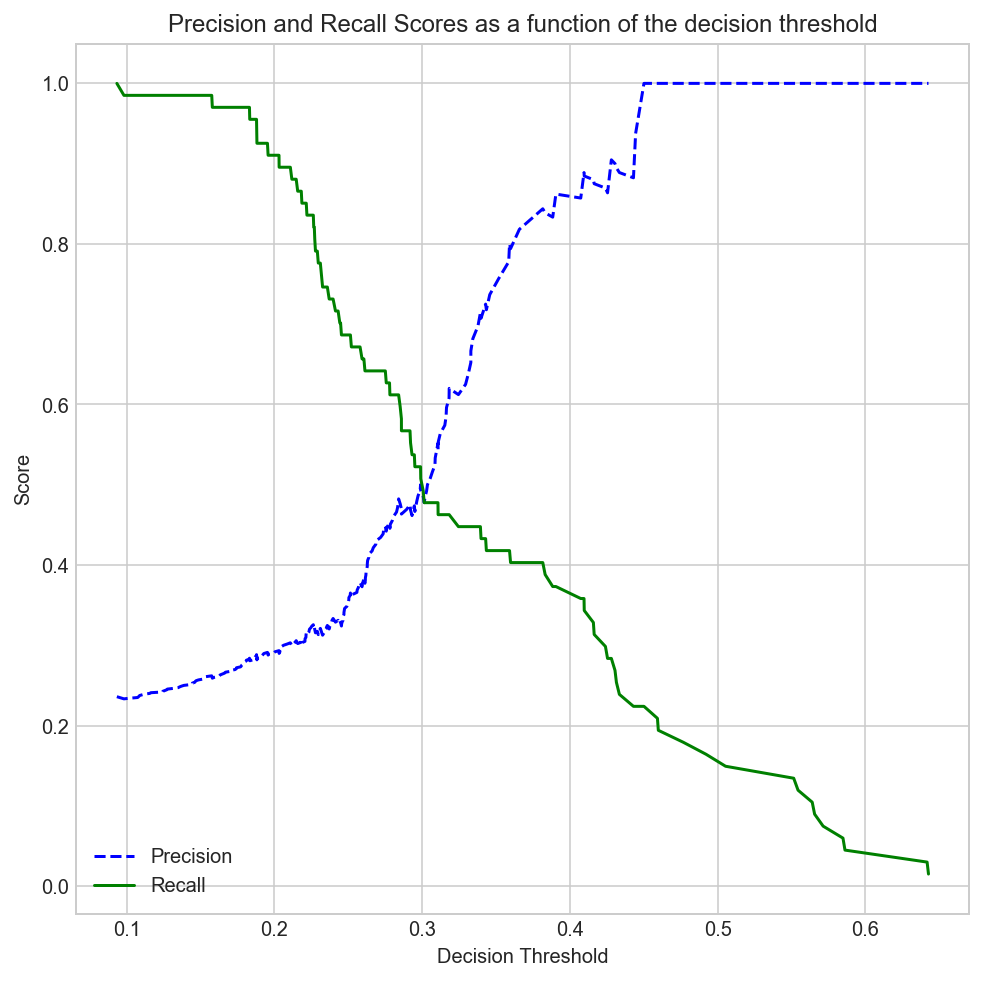

In [321]:
plot_precision_recall_vs_threshold(p, r, thresholds)

The idea to answer this question is have 1.0 precision when predicting 75th percentile(high salary). You rather tell everyone they're getting lower pay unless you're quite sure they deserve high pay.  So after adjusting the threshold, those who do not pass the threshold should only be informed of the lower salary, even in truth they're qualified for high pay.

# QUESTION 2: Factors that distinguish job category

## EDA and Data Cleaning

In [64]:
df_q2 = working_df[["job_title", "job_description"]]

In [65]:
df["job_title"].value_counts()

Business Analyst                                                                              292
Data Analyst                                                                                  199
Data Scientist                                                                                133
Business Intelligence                                                                          40
Data Engineer                                                                                  22
Scientist (Data Analytics)  /  I2R (A*STAR)                                                     8
Senior Data Engineer                                                                            5
Data Scientist, APAC (Singapore)                                                                4
Data Analyst Intern                                                                             4
Research Engineer (Data Analytics)  /  I2R (A*STAR)                                             4
Account Coordinator 

In [66]:
# used for replacing unwanted characters
import re

def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [67]:
# used for combining job titles into simpler categories
def aggregate_job_title(job_title):
    data = "data"
    scientist = "scientist"
    science = "science"
    scientists = "scientists"
    analyst = "analyst"
    analytics = "analytics"
    engineer = "engineer"
    business = "business"
    intelligence = "intelligence"
    big = "big"
    if len([x for x in job_title.split() if x.lower() == data]) > 0:
        if len([x for x in job_title.split() if (x.lower() == scientist) | (x.lower() == science)| (x.lower() == scientists)]) > 0:
            return "Data Scientist"
        elif len([x for x in job_title.split() if (x.lower() == analyst) | (x.lower() == analytics)]) > 0:
            return "Data Analyst"
        elif len([x for x in job_title.split() if (x.lower() == engineer) | (x.lower() == big)]) > 0:
            return "Data Engineer"
        else :
            return job_title
    elif len([x for x in job_title.split() if x.lower() == business]) > 0:
        if len([x for x in job_title.split() if x.lower() == analyst]) > 0:
            return "Business Analyst"
        elif len([x for x in job_title.split() if x.lower() == intelligence]) > 0:
            return "Data Analyst"
        else:
            return job_title
        
subst = { "," : " ", "(" : " ", ")" : " ", ":" : " ", "/" : " "}
df_q2['group'] = df_q2['job_title'].apply(lambda x : replace(x, subst)).apply(aggregate_job_title)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
titles_of_interest = ["Data Scientist", "Data Analyst", "Data Engineer", "Business Analyst"]
df_q2 = df_q2.loc[df_q2['group'].isin(titles_of_interest)]

In [69]:
X_q2 = df_q2["job_description"]
y_q2 = df_q2["group"]

In [70]:
X_q2 = X_q2.apply(lambda x : re.sub('[^a-zA-Z]', ' ', x))
X_q2 = X_q2.apply(apply_words_split)

In [71]:
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X_q2, y_q2, random_state=1)

In [72]:
# use TfidfVectorizer to create document-term matrices from X_train and X_test
vect = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=4)
X_train_dtm_q2 = vect.fit_transform(X_train_q2)
X_test_dtm_q2 = vect.transform(X_test_q2)

In [74]:
X_train_dtm_q2.shape

(717, 10043)

## SGD Classifier 

In [75]:
tuned_parameters = {'alpha': [10**a for a in range(-6, 5)], 
                   'penalty': ['elasticnet', 'l1', 'l2'],
                   'loss': ['hinge', 'log']}
clf_q2 = GridSearchCV(SGDClassifier( max_iter=10, shuffle=False, verbose=False, n_jobs=10, average=False, class_weight='balanced'), tuned_parameters, cv=5, scoring='f1_macro')

# Now clf is the best classifier found given the search space
clf_q2.fit(X_train_dtm_q2, y_train_q2)

# Check the propeties of your model
print(clf_q2.best_params_)    

print classification_report(y_test_q2, clf_q2.predict(X_test_dtm_q2))

{'penalty': 'elasticnet', 'alpha': 0.001, 'loss': 'hinge'}
                  precision    recall  f1-score   support

Business Analyst       0.88      0.92      0.90        74
    Data Analyst       0.88      0.79      0.83        80
   Data Engineer       0.67      0.85      0.75        26
  Data Scientist       0.84      0.82      0.83        60

     avg / total       0.85      0.84      0.84       240



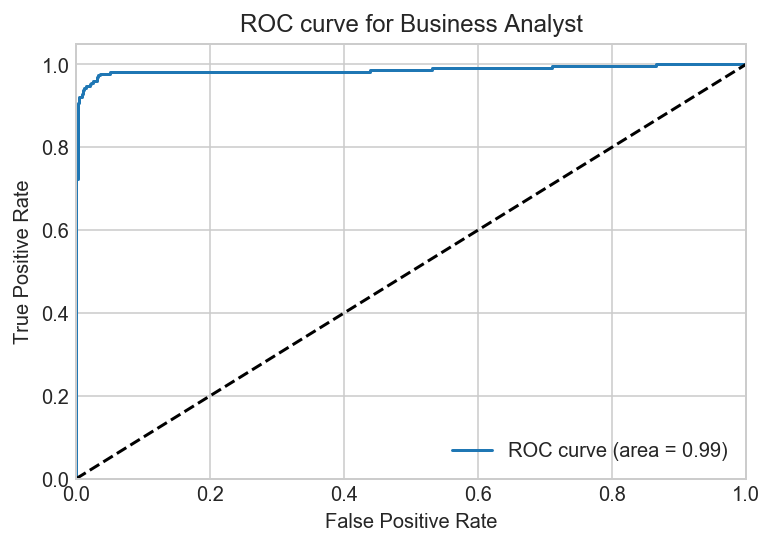

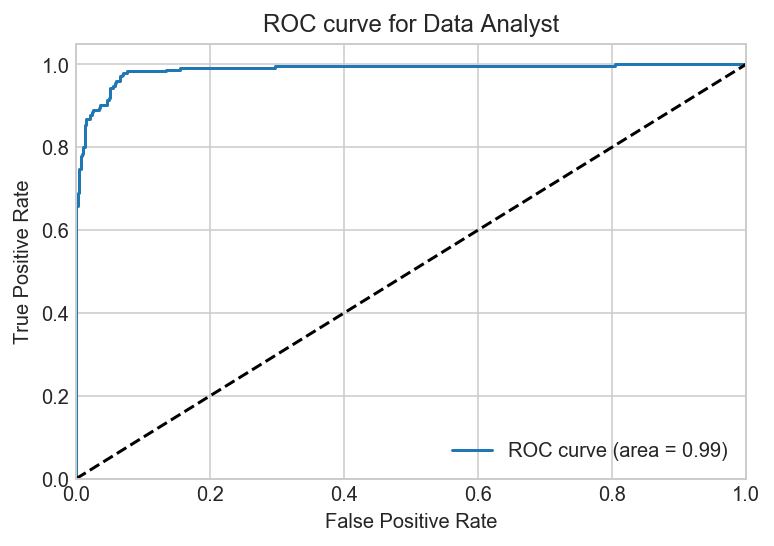

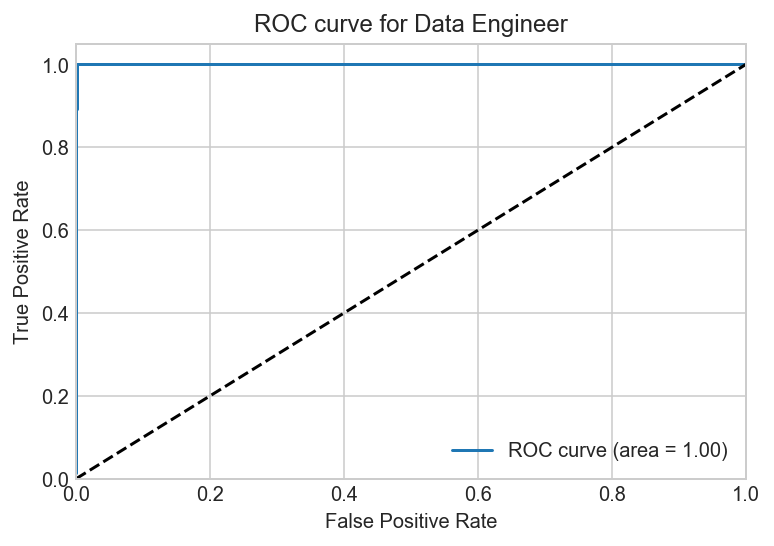

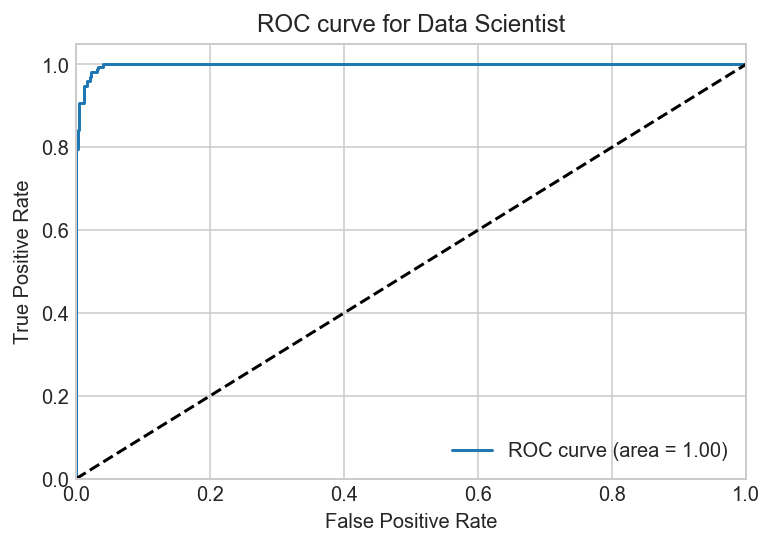

In [79]:
categories =["Business Analyst", "Data Analyst" ,"Data Engineer", "Data Scientist"]

y_score = clf_q2.decision_function(X_train_dtm_q2)
y_test_roc = label_binarize(y_train_q2, classes=categories)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(len(categories)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + str(categories[i]))
    plt.legend(loc="lower right")
    plt.show()

In [96]:

clf_coefs_0 = pd.DataFrame({'feature':vect.get_feature_names(),
                            'business analyst':clf_q2.best_estimator_.coef_[0]})
clf_coefs_1 = pd.DataFrame({'feature':vect.get_feature_names(),
                         'data analyst':clf_q2.best_estimator_.coef_[1]})
clf_coefs_2 = pd.DataFrame({'feature':vect.get_feature_names(),
                         'data engineer':clf_q2.best_estimator_.coef_[2]})
clf_coefs_3 = pd.DataFrame({'feature':vect.get_feature_names(),
                         'data scientist':clf_q2.best_estimator_.coef_[3]})

clf_coefs_0.sort_values('business analyst', inplace=True, ascending=False)
clf_coefs_1.sort_values('data analyst', inplace=True, ascending=False)
clf_coefs_2.sort_values('data engineer', inplace=True, ascending=False)
clf_coefs_3.sort_values('data scientist', inplace=True, ascending=False)

display_css('clf_coefs_0.head(50)','clf_coefs_1.head(50)', 
            'clf_coefs_2.head(50)', 'clf_coefs_3.head(50)') 


,business analyst,feature
1053,2.606048,business analyst
1049,2.433082,business
3571,1.917661,financial
100,1.183453,accounting
4189,1.175699,implementation
398,1.090170,analyst
7807,1.035843,sap
3722,1.025675,functional
3561,1.009361,finance
6862,1.004625,project


You can infer from the 4 tables above which features/keywords have strong impacts on its group

## Random Forest Classifier

SVM (SGD Classifier) has better scores than random forest classifier

In [77]:
RF_clf = RandomForestClassifier()
RF_scores = cross_val_score(RF_clf, X_train_dtm_q2, y_train_q2, cv=10)

RF_clf.fit(X_train_dtm_q2, y_train_q2)
print RF_scores
print np.mean(RF_scores)

print classification_report(y_test_q2, RF_clf.predict(X_test_dtm_q2))

[0.77027027 0.76712329 0.69863014 0.84931507 0.68055556 0.78873239
 0.84507042 0.84285714 0.75714286 0.67142857]
0.7671125707306491
                  precision    recall  f1-score   support

Business Analyst       0.82      0.88      0.85        74
    Data Analyst       0.68      0.80      0.74        80
   Data Engineer       0.86      0.46      0.60        26
  Data Scientist       0.83      0.73      0.78        60

     avg / total       0.78      0.77      0.77       240

